In [1]:
from datasets import load_dataset
import evaluate
import torch
from transformers import MT5ForConditionalGeneration, MT5Tokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Load dataset
dataset = load_dataset("parquet", data_files={
    "train": "data/iamTangsang_dataset/train-00000-of-00001.parquet",
    "validation": "data/iamTangsang_dataset/validation-00000-of-00001.parquet", 
    "test": "data/iamTangsang_dataset/test-00000-of-00001.parquet"
})

# Subset the data
train_size, val_size, test_size = 50000, 5000, 2000
dataset["train"] = dataset["train"].select(range(train_size))
dataset["validation"] = dataset["validation"].select(range(val_size))
dataset["test"] = dataset["test"].select(range(test_size))


/Users/ishanawal/miniforge3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [2]:
# Filter empty or very long samples
def is_valid_pair(example):
    source, target = str(example["source"]).strip(), str(example["target"]).strip()
    return 0 < len(source) < 300 and 0 < len(target) < 300

dataset = dataset.filter(is_valid_pair)

print("Dataset sizes after filtering:")
print(f"Train: {len(dataset['train'])}")
print(f"Validation: {len(dataset['validation'])}")
print(f"Test: {len(dataset['test'])}")

Dataset sizes after filtering:
Train: 49746
Validation: 4977
Test: 1991


In [3]:
# Load tokenizer and model
# checkpoint_path = "./mt5-npi-en/checkpoint-99480" 
tokenizer = MT5Tokenizer.from_pretrained('google/mt5-small', legacy=False)
model = MT5ForConditionalGeneration.from_pretrained('google/mt5-small')
model.config.use_cache = False
model.to(device).float()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [4]:
# Preprocessing function
def preprocess_function(examples):
    inputs = ["translate Nepali to English: " + str(src).strip() for src in examples["source"]]
    targets = [str(tgt).strip() for tgt in examples["target"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=256, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(token_id if token_id != tokenizer.pad_token_id else -100) for token_id in label]
        for label in model_inputs["labels"]
    ]
    return model_inputs

In [5]:
# Tokenize datasets
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
tokenized_dataset.set_format(type="torch")

In [6]:
bleu = evaluate.load("bleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    bleu_score = bleu.compute(predictions=decoded_preds, references=decoded_labels)["bleu"]
    return {"bleu": bleu_score}


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


In [7]:
# Data collator
class CustomDataCollator(DataCollatorForSeq2Seq):
    def __call__(self, features, return_tensors=None):
        batch = super().__call__(features, return_tensors=return_tensors)
        # Convert labels to tensor safely
        if isinstance(batch["labels"], list):
            labels = [np.array(x, dtype=np.int64) for x in batch["labels"]]
            batch["labels"] = torch.tensor(labels)
        return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}



data_collator = CustomDataCollator(tokenizer=tokenizer, model=model)


In [8]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-npi-en",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir="./logs",
    logging_steps=500,
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    generation_max_length=280,
    weight_decay=0.01,
    save_total_limit=3,
    warmup_steps=500,
    predict_with_generate=True,
    dataloader_pin_memory=False,
    fp16=False,
    dataloader_num_workers=0,
    remove_unused_columns=False,
    use_cpu=False,
    report_to=None,
)


In [9]:
class CustomTrainer(Seq2SeqTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_losses = []
        self.eval_losses = []
        self.bleu_scores = []

    def log(self, logs, step=None, **kwargs):
        super().log(logs)
        if "loss" in logs:
            self.train_losses.append(logs["loss"])

    def evaluate(self, *args, **kwargs):
        metrics = super().evaluate(*args, **kwargs)
        self.eval_losses.append(metrics.get("eval_loss", None))
        return metrics

    def save_metrics_plot(self):
        epochs = list(range(1, len(self.eval_losses) + 1))

        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label="Training Loss", marker="o")
        plt.plot(epochs, self.eval_losses, label="Validation Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Metric Value")
        plt.title("Training Metrics")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("training_metrics.png")
        plt.show()


In [10]:
# Trainer setup
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/var/folders/mb/dzlftm2s7f70n50rgqtnzkq80000gn/T/ipykernel_2215/662922639.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [11]:
trainer.train()

/Users/ishanawal/miniforge3/envs/myenv/lib/python3.11/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Epoch,Training Loss,Validation Loss
1,3.555200,2.150514
2,2.542300,2.010257
3,2.382900,1.977713


TrainOutput(global_step=74619, training_loss=2.8268030762942415, metrics={'train_runtime': 39208.2692, 'train_samples_per_second': 3.806, 'train_steps_per_second': 1.903, 'total_flos': 3.945477318377472e+16, 'train_loss': 2.8268030762942415, 'epoch': 3.0})

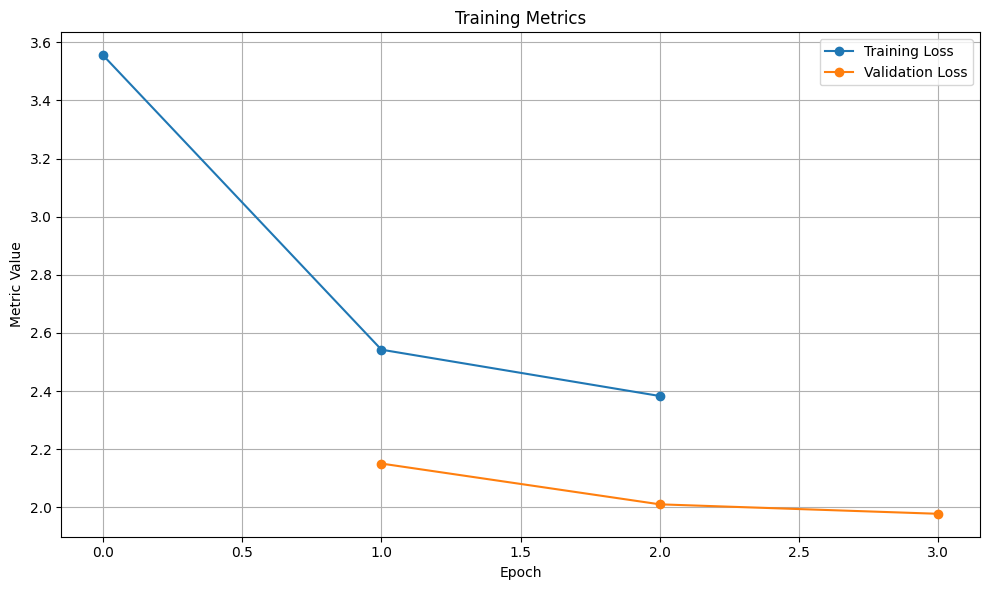

In [13]:
trainer.save_model("./mt5-npi-en")
tokenizer.save_pretrained("./mt5-npi-en")
trainer.save_metrics_plot()

In [14]:
test_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
print("Test Evaluation:", test_results)

Test Evaluation: {'eval_loss': 1.9567415714263916, 'eval_runtime': 101.8246, 'eval_samples_per_second': 19.553, 'eval_steps_per_second': 9.782, 'epoch': 3.0}


In [15]:
# Evaluation with BLEU
bleu = evaluate.load("bleu")
model.eval()
sources, references = dataset["test"]["source"], dataset["test"]["target"]
predictions, batch_size = [], 4

for i in tqdm(range(0, len(sources), batch_size), desc="Generating translations"):
    batch_inputs = ["translate Nepali to English: " + s for s in sources[i:i+batch_size]]
    inputs = tokenizer(batch_inputs, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=256, num_beams=4)
    predictions.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))

# Print samples and compute BLEU
for i in range(min(10, len(sources))):
    print(f"\nSource: {sources[i]}\nReference: {references[i]}\nPredicted: {predictions[i]}")
print("Test BLEU:", bleu.compute(predictions=[p.strip() for p in predictions], references=[[r.strip()] for r in references])["bleu"])


Generating translations: 100%|██████████| 498/498 [17:28<00:00,  2.11s/it] 


Source: यसबाट युवकहरु पनि पीडित भएको देखिन्छन ।
Reference: Young people also suffer from it.
Predicted: The young people are also injured.

Source: बजाऊने लिस्ट
Reference: Playlist
Predicted: Writing Page

Source: त्यहाँ केही नियमहरू छन् जुन तपाईंले पछ्याउनु पर्छः
Reference: There are a few rules that you should follow:
Predicted: There are some rules that you need to follow:

Source: सबै गीतहरु उनी आफैंले लेखेका हुन् ।
Reference: All songs were written by himself.
Predicted: He wrote all the songs.

Source: मेरो एउटा जर्मन साथी छ ।
Reference: I had a German friend.
Predicted: I have a German friend.

Source: तपाईँ वास्तवमै फाइल मेट्न चाहनुहुन्छ?

Reference: Do you really want to delete file ?

Predicted: Do you want to delete the file?

Source: यस कुरालाई लिएर आक्रोशित हुनुपर्ने कुनै आवश्यकता छैन ।
Reference: There is no need to get upset about this.
Predicted: There is no need to be aware of this.

Source: पुरुष र महिला दुबैले यसको लाभ उठाउन सक्छन्।
Reference: Both women and men can